<a href="https://colab.research.google.com/github/japheth-kasomo/Modelling-using-R/blob/main/AIMS_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -qq install catboost

     |████████████████████████████████| 65.8MB 65kB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd "/content/drive/MyDrive/Colab Notebooks/dataset"

/content/drive/MyDrive/Colab Notebooks/dataset


In [7]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hakathon_two/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hakathon_two/Test.csv')
sample = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hakathon_two/SampleSubmission.csv')

In [8]:
train.shape, test.shape, sample.shape

((21454, 19), (7194, 18), (7194, 2))

In [9]:
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


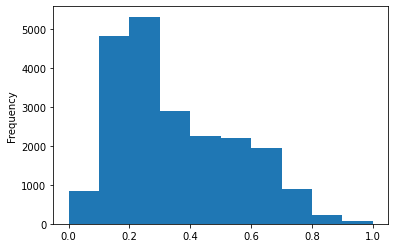

In [10]:
target = train.Target
train.Target.plot(kind = 'hist');

In [11]:
test.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,Uganda,2011,U,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334
3,ID_AAmMOEEC,Burkina Faso,2010,U,0.000000,0.000089,0.000036,0.001519,0.001358,0.996997,35.141762,33.878927,4.166437,0.000000,0.130727,1.333999,109.493969,775.139189
4,ID_ABguzDxp,Zambia,2007,R,0.000000,0.000138,0.000623,0.000615,0.002961,0.995663,3.442449,33.491994,3.437129,0.133563,0.128997,0.502203,133.643319,835.591501


In [12]:
set(train.country).difference(set(test.country))

{'Cameroon',
 'Central African Republic',
 "Cote d'Ivoire",
 'Ethiopia',
 'Ghana',
 'Guinea',
 'Kenya',
 'Lesotho',
 'Malawi',
 'Mali',
 'Mozambique',
 'Nigeria',
 'Rwanda',
 'Senegal',
 'Sierra Leone',
 'Swaziland',
 'Tanzania',
 'Togo'}

In [13]:
set(train.country).intersection(set(test.country))

set()

In [14]:
train.country.nunique(), test.country.nunique()

(18, 7)

In [15]:
le = LabelEncoder()
train.urban_or_rural = le.fit_transform(train.urban_or_rural)
test.urban_or_rural = le.transform(test.urban_or_rural)

In [16]:
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,0,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,0,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,0,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,1,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In [17]:
%%time
X = train.copy()
y = train.Target

main_features = train.columns.difference(['ID', 'Target', 'year', 'country'])
tess = test[main_features]

feature_importance_df = pd.DataFrame()
folds = KFold(n_splits = 5, random_state=0)

predictions = []
rmses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
  X_train, X_test = X_train[main_features], X_test[main_features]
  
  model = LGBMRegressor(n_estimators=4000, eval_metric = 'rmse', learning_rate=0.1)
  model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose = False)

  preds = model.predict(tess)
  y_pred = model.predict(X_test) 

  predictions.append(preds)
  rmse = mean_squared_error(y_test, y_pred)**0.5

  fold_importance_df = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.feature_importances_})
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
  print(i, rmse)
  rmses.append(rmse)

print(f'Mean RMSE: {np.mean(rmses)}')
# Averaging predictions
mpreds = np.mean(predictions, 0)

# Submission file creation
ss = sample.copy()
ss['Target'] = mpreds
ss.to_csv('Baseline.csv', index=False)

0 0.10316716520352186
1 0.10147958775624381
2 0.10189364107191645
3 0.0986934777463037
4 0.10116267191254302
Mean RMSE: 0.10127930873810578
CPU times: user 13.9 s, sys: 232 ms, total: 14.2 s
Wall time: 7.37 s


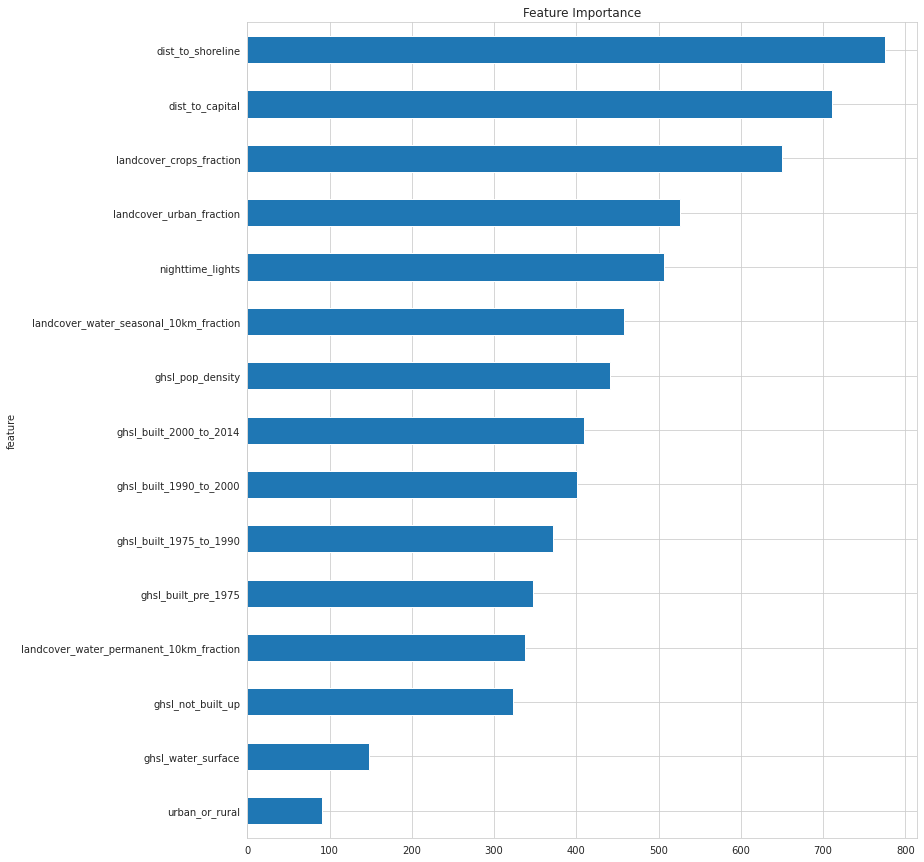

In [18]:
# Feature Importance plot
sns.set_style('whitegrid')
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values(ascending=False)[::-1].plot(kind = 'barh', figsize=(12, 15), title = 'Feature Importance')
plt.show()